In [7]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 
import numpy as np

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [9]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 0 0 1 1 2 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 2 1 0 1 0 0 1]


2024-10-25 19:19:47.475458: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for image_batch, label_batch in dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Adjusted label batch:", label_batch.numpy())

Image batch shape: (32, 256, 256, 3)
Adjusted label batch: [2 1 1 0 1 2 0 0 2 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 2 0 0 0 1 0 0 0]


2024-10-25 19:19:47.532401: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


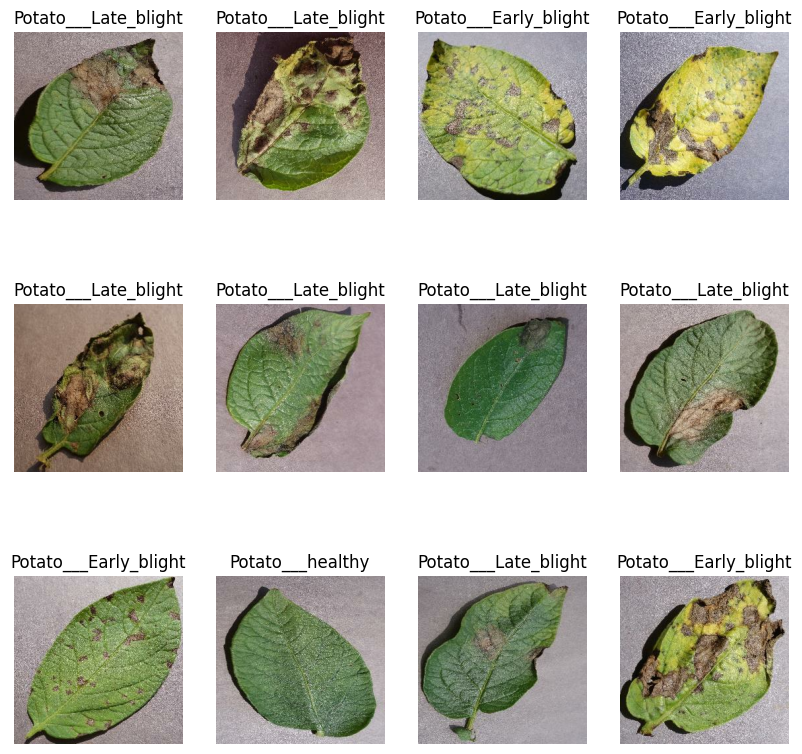

In [14]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
   

In [15]:
len(dataset)

68

## Now we are going to split the data for traning, validation and testing (80%, 10%, 10%)

In [16]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [17]:
train_ds = dataset.take(54)
len(train_ds)

54

In [18]:
VTdata = dataset.skip(54) 
len(VTdata)

14

In [19]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [20]:
val_ds = VTdata.take(6)
len(val_ds)

6

In [21]:
test_ds = VTdata.skip(6)
len(test_ds)

8

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle =True, shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split *ds_size)
    val_size = int(val_split *ds_size)

    trian_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [24]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 


In [26]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)

])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [29]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, BATCH_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation= 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (2,2), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (2,2), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation ='softmax')
])
model.build(input_shape=input_shape)

/Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/plantdisease/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (256, 256, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (256, 256, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (256, 254, 254, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (256, 127, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (256, 126, 126, 64)    │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (256, 63, 63, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (256, 62, 62, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (256, 31, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (256, 29, 29, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (256, 14, 14, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (256, 12, 12, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (256, 6, 6, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (256, 2304)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (256, 64)              │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (256, 3)               │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,171 (965.51 KB)

 Trainable params: 247,171 (965.51 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
               
               )

In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',         
    patience=3,                     
    restore_best_weights=True       
)

# Define model checkpointing
import os

# Define the project root directly
project_root = '/Users/rohitsunny/Documents/Projects/Plant-disease-Classification-'

# Define the checkpoint path with .keras extension
checkpoint_path = os.path.join(project_root, "models", "checkpoint_model_{epoch:02d}.keras")

# Ensure the models directory exists
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,       # Path to save the model
    save_weights_only=False,        # Save the entire model, not just weights
    save_best_only=True,            # Only save the model if it's the best seen so far
    monitor='val_loss',             # Or 'val_accuracy', based on your preference
    verbose=1
)

# Train the model with both callbacks
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]  # Include both callbacks
)


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4811 - loss: 0.9409
Epoch 1: val_loss improved from inf to 0.95016, saving model to /Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/models/checkpoint_model_01.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.4825 - loss: 0.9395 - val_accuracy: 0.5595 - val_loss: 0.9502
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7725 - loss: 0.5915
Epoch 2: val_loss improved from 0.95016 to 0.45632, saving model to /Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/models/checkpoint_model_02.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7731 - loss: 0.5901 - val_accuracy: 0.8393 - val_loss: 0.4563
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8312 - loss: 0.3930
Epoch 3: val_loss improved from 0.45632 to 0.26894, saving model to /Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/models/checkpoint_model_03.keras
54/54 ━━━━━━━━━━━━━

In [36]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.9583 - loss: 0.1324


In [37]:
scores

[0.14821532368659973, 0.953125]

In [38]:
history 

In [39]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [40]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [41]:
history.history['accuracy']

[0.5567129850387573,
 0.8043981194496155,
 0.8524305820465088,
 0.8773148059844971,
 0.9201388955116272,
 0.9571759104728699,
 0.9508101940155029,
 0.9699074029922485]

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

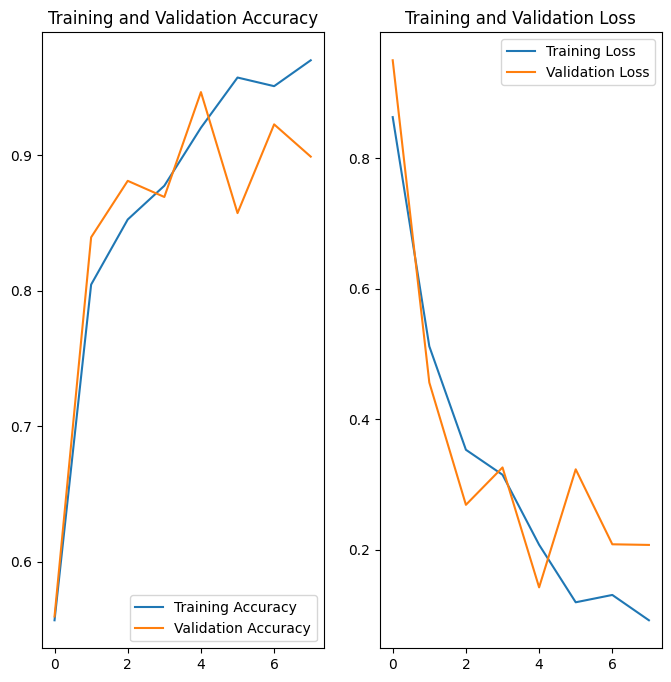

In [43]:
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
predicted label: Potato___Late_blight


2024-10-25 19:49:45.866812: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


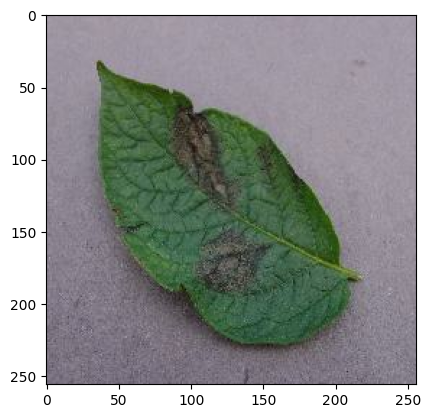

In [44]:

for image_batch, label_batch in dataset.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


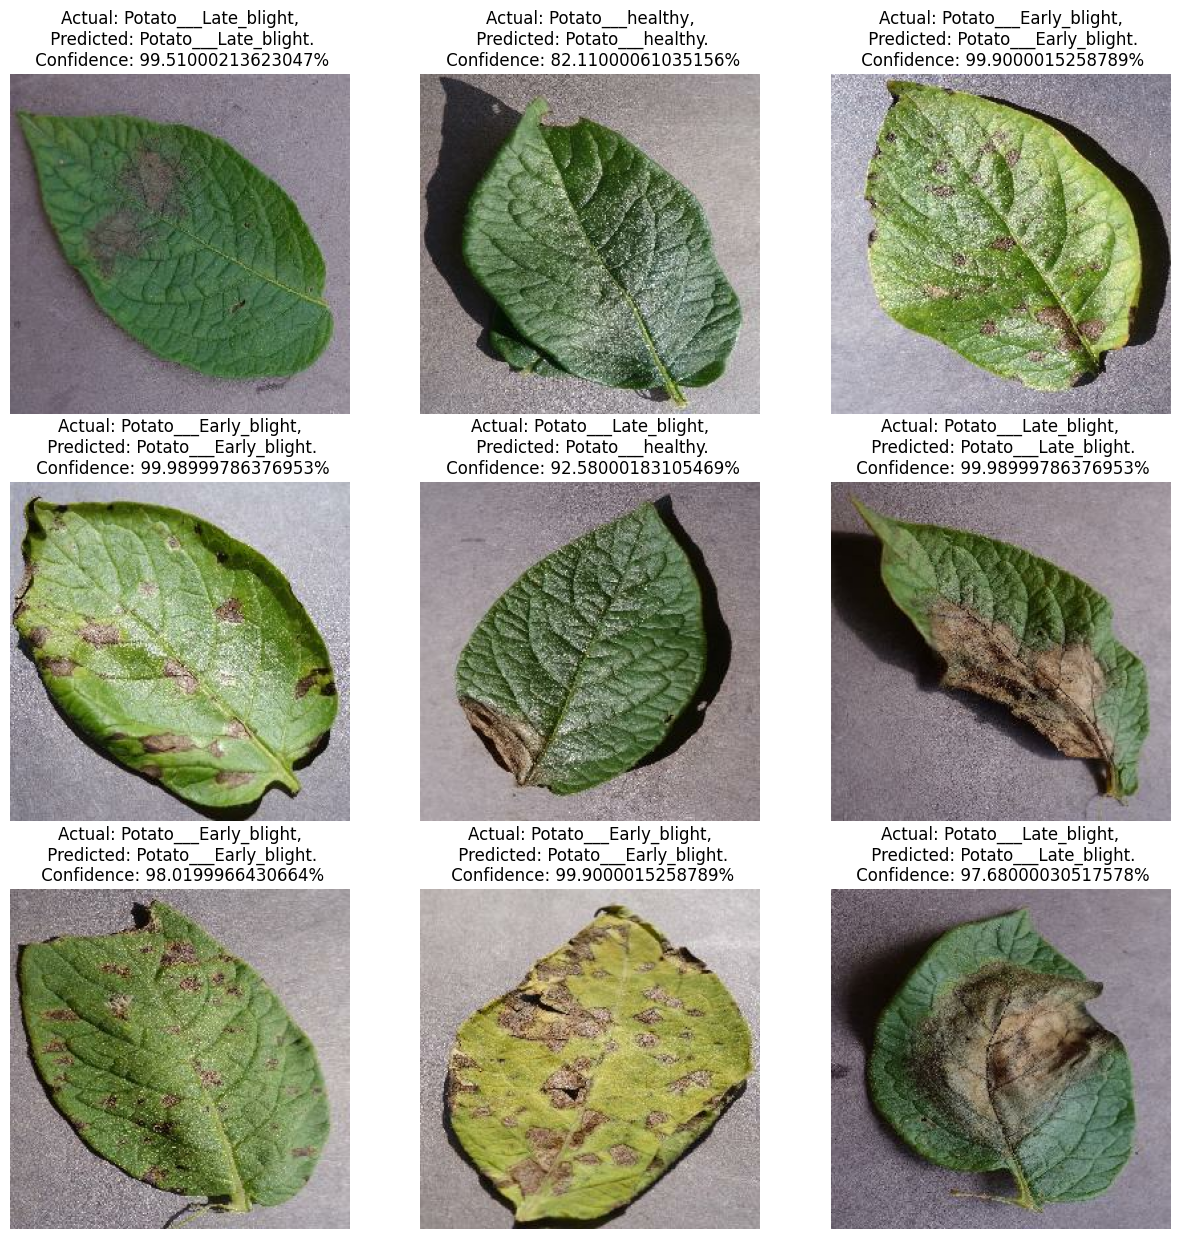

In [46]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

## Saving the model in tf 

In [47]:
final_model_path = os.path.join(project_root, "models", "final_plant_disease_model.keras")
model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")

Final model saved to: /Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/models/final_plant_disease_model.keras


In [52]:
import os


models_dir = '/Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/models'

os.makedirs(models_dir, exist_ok=True)

# Get the next model version number
existing_models = [d for d in os.listdir(models_dir) if os.path.isdir(os.path.join(models_dir, d)) and d.startswith("model_")]
model_version = len(existing_models) + 1

new_model_dir = os.path.join(models_dir, f"model_{model_version}")

# Export the model in SavedModel format
model.export(new_model_dir)

print(f"Model exported as: {new_model_dir}")

INFO:tensorflow:Assets written to: /Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/models/model_2/assets


INFO:tensorflow:Assets written to: /Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/models/model_2/assets


Saved artifact at '/Users/rohitsunny/Documents/Projects/Plant-disease-Classification-/models/model_2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5099468224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099469104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099941728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099940496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099949392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099949216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099967760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099967408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099969696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5099969520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [41]:

loaded_model = tf.saved_model.load(f"../models/model_{model_version}")

In [42]:
import os

def get_next_version(base_path):
    # Get all items in the directory
    items = os.listdir(base_path)
    
    # Filter for directories that match the pattern "model_XX"
    existing_models = [item for item in items if os.path.isdir(os.path.join(base_path, item)) and item.startswith("model_")]
    
    # Extract version numbers
    version_numbers = [int(model.split("_")[1]) for model in existing_models if model.split("_")[1].isdigit()]
    
    # Determine the next version number
    if version_numbers:
        next_version = max(version_numbers) + 1
    else:
        next_version = 1
    
    # Format the version number as a two-digit string
    return f"{next_version:02d}"

# Set the base path for models
base_path = "../models"

# Get the next version number
model_version = get_next_version(base_path)

# Export the model with the new version number
model.export(f"{base_path}/model_{model_version}")

print(f"Model exported as model_{model_version}")

INFO:tensorflow:Assets written to: ../models/model_02/assets


INFO:tensorflow:Assets written to: ../models/model_02/assets


Saved artifact at '../models/model_02'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5231142512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231143392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231625136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231630464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231631872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231631696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231662528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231662176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231664464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231664288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5231682832: TensorSpec(shape=(), dtype=tf.resource, name=None)
